# Clustering: Practical Exercise

In [1]:
# Uncomment to upgrade packages
# !pip install pandas --upgrade --user --quiet
# !pip install numpy --upgrade --user --quiet
# !pip install scipy --upgrade --user --quiet
# !pip install statsmodels --upgrade --user --quiet
# !pip install scikit-learn --upgrade --user --quiet
# !pip install matplotlib --upgrade --user --quiet

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


Now we are going to explore a dataset of customers from a Wholesale distributor taken from 
the UCI Machine Learning Repository (https://archive.ics.uci.edu/ml/datasets/Wholesale+customers) 
using the clustering algorithms that we have seen in the lab session.

We have the data as a csv file among the files of this session, we can load it this way:

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [4]:
wholesale =  pd.read_csv("Wholesale customers data.csv", sep=',')

These are the dimensions of the dataset and the names of the variables

In [5]:
wholesale.shape
wholesale.columns
wholesale.head()

(440, 8)

Index(['Channel', 'Region', 'Fresh', 'Milk', 'Grocery', 'Frozen',
       'Detergents_Paper', 'Delicassen'],
      dtype='object')

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


According to the documentation the variables **channel** and **region** are categorical, 
so we will convert them to the categorical data type 
and we will use the labels that appear on the documentation

In [6]:
wholesale.Channel.replace([1,2],['horeca', 'retail'], inplace=True)
wholesale.Channel = wholesale.Channel.astype('category')
wholesale.Region.replace([1,2,3],['Lisbon', 'Oporto', 'Other'], inplace=True)
wholesale.Region = wholesale.Region.astype('category')

wholesale.dtypes

Channel             category
Region              category
Fresh                  int64
Milk                   int64
Grocery                int64
Frozen                 int64
Detergents_Paper       int64
Delicassen             int64
dtype: object

As usual we will start with the descriptive statistics of the data

In [7]:
wholesale.describe(include='all')

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440,440,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
unique,2,3,NaN,NaN,NaN,NaN,NaN,NaN
top,horeca,Other,NaN,NaN,NaN,NaN,NaN,NaN
freq,298,316,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,NaN,NaN,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,NaN,NaN,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,NaN,NaN,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,NaN,NaN,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,NaN,NaN,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000


And also some plots of the variables to chech their distribution and to spot outliers or skewed distributions.

/usr/lib/python3.9/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


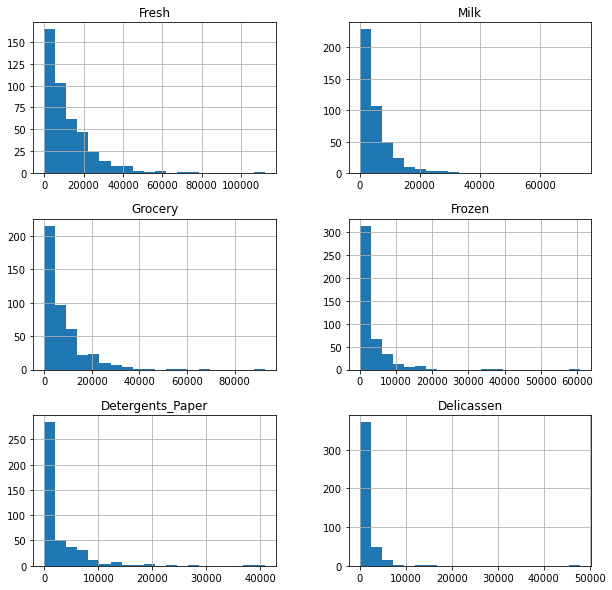

In [8]:
wholesale.hist(bins=20,figsize=(10,10));

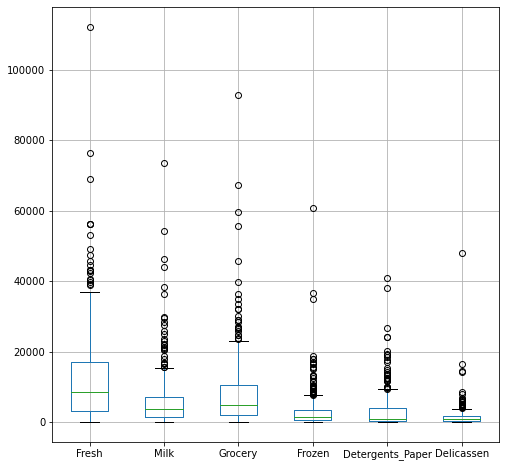

In [9]:
fig = plt.figure(figsize=(8,8))
wholesale.boxplot(figsize=(10,10));

You will see that there are some extreme values that skew the distributions (basically outliers).

In [10]:
wholesale = wholesale[(wholesale.Fresh<80000) & (wholesale.Milk<60000) & (wholesale.Grocery<80000) & (wholesale.Frozen<40000) & (wholesale.Detergents_Paper<30000) & (wholesale.Delicassen<20000) ]

# Visualizing patterns

We can not visualize all the variables at the same time, but we can visualize pairs of variables to see if there are clusters of examples.

This is no guarantee that there are clusters on more dimensions, but until we learn how to transform multidimensional data to two or three dimensions it will do

Visualize different groups of variables and check if outliers are still a problem

/usr/lib/python3.9/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


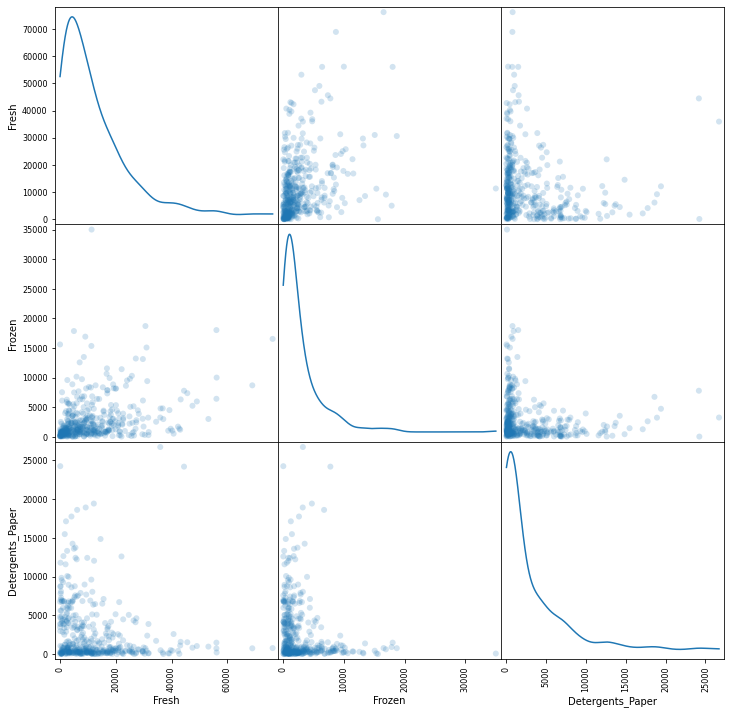

In [11]:
from pandas.plotting import scatter_matrix

scatter_matrix(wholesale.loc[:,['Fresh','Frozen','Detergents_Paper']], alpha=0.2, figsize=(12, 12), diagonal='kde', marker='o');

We can also make some 3D visualizations.

Check also for remaining outliers.

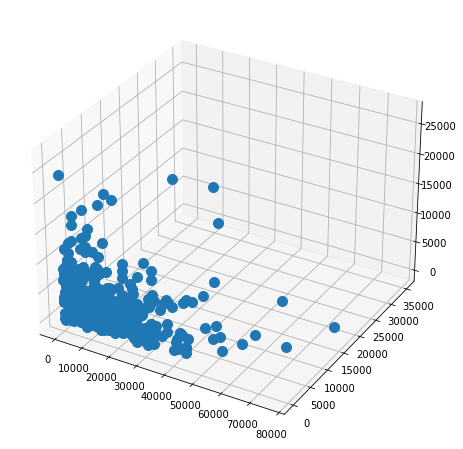

In [12]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
plt.scatter(wholesale['Fresh'], wholesale['Frozen'], zs=wholesale['Detergents_Paper'], depthshade=False, s=100);

# Clustering

In [13]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

Now we can try to partition the data using the two clustering algorithms that we have seen in this session, but first we will generate a dataset without the categorical variables because we can not use it with these algorithms and also maybe these variables are related with the clusters in the data, so we do not want to make it easy for the algorithms :-)

In [14]:
newwholesale = wholesale.drop(columns=['Channel', 'Region'])

In [15]:
newwholesale.describe()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000
mean,11637.808756,5380.923963,7498.677419,2846.447005,2678.338710,1391.195853
std,11666.891741,5978.540285,8037.150522,3615.426198,4012.680087,1706.148925
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3098.500000,1515.750000,2146.250000,738.750000,256.250000,405.250000
50%,8257.500000,3607.500000,4725.000000,1526.000000,811.000000,960.500000
75%,16724.500000,7091.500000,10391.000000,3519.750000,3879.250000,1783.000000
max,76237.000000,54259.000000,59598.000000,35009.000000,26701.000000,16523.000000


Now is your time to find clusters in the data

- Review the notebook of this session and replicate the code to assess how many clusters are adequate for this data using K-means
    - Explore a range of number of clusters  and save the Kalinski-Harabasz index for each number of clusters
    - Plot the number of clusters vs the index and see if there is a number of clusters that seems more adequate
- Use the EM algortihm with the best number of clusters and find a clustering for the data using the "diag" and "full" covariance
- Extract the assigments of the best solutions for k-means and EM, create a dataframe with them and use the crosstab function to compute a contingecy table of the assignments. Do the partitions from both methods agree?



In [16]:
#%matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from collections import Counter
from IPython.core.interactiveshell import InteractiveShell
pd.set_option('precision', 3)
InteractiveShell.ast_node_interactivity = "all"

In [17]:
# Extra imports
from numpy.random import  uniform,normal
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score, silhouette_score, davies_bouldin_score
from numpy.random import multivariate_normal
from sklearn.datasets import make_blobs
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.preprocessing import minmax_scale
from time import time
from datetime import timedelta

In [18]:
index= pd.MultiIndex.from_arrays([['kmeans'], [3]], names=('model', 'K'))
results_df = pd.DataFrame(index=index, columns= ['CH score', 'Silhouette score', 'DB score'])

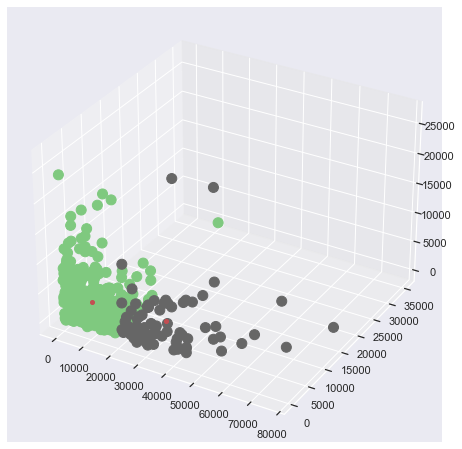

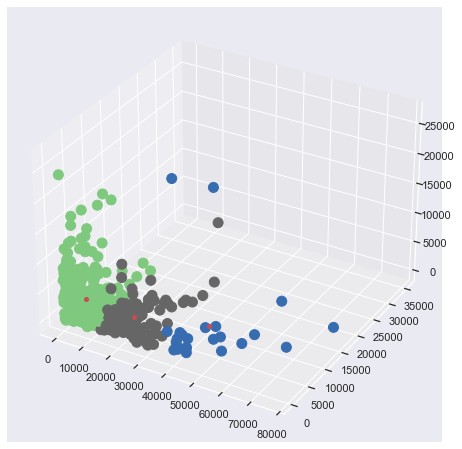

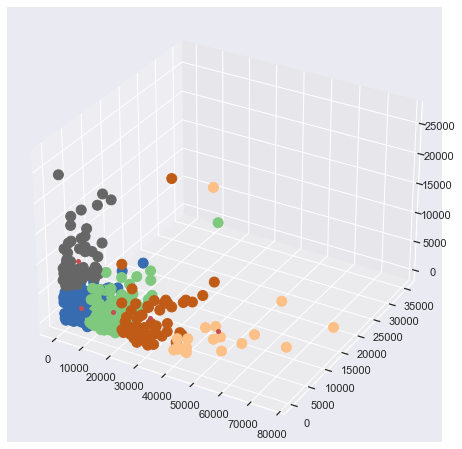

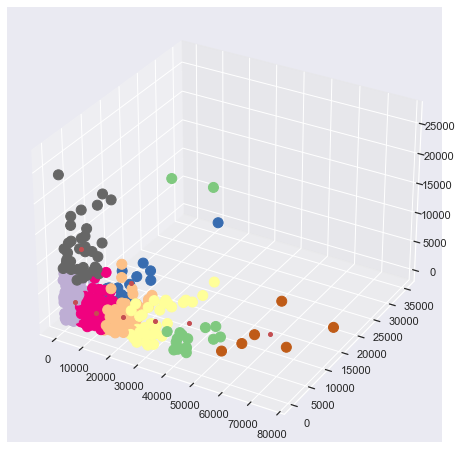

In [19]:
def compute_clustering_and_plot(K, data, results):
    # Train the model
    # labels = ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']
    labels = ['Fresh', 'Frozen', 'Detergents_Paper']
    kmeans = KMeans(n_clusters=K, max_iter=100)
    kmeans.fit(data.loc[:,labels]);
    data['kmeans_labels'] = kmeans.labels_
    
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')
    plt.scatter(data['Fresh'], 
                data['Frozen'], 
                zs=data['Detergents_Paper'], 
                depthshade=False,
                c=data['kmeans_labels'],
                s=100, cmap="Accent");
    plt.plot(kmeans.cluster_centers_[:,0], 
             kmeans.cluster_centers_[:,1],
             kmeans.cluster_centers_[:,2],
             'r.', markersize=8,alpha=1);
        
    # Compute metrics
    CH = calinski_harabasz_score(data.loc[:,labels], 
                              kmeans.labels_ )
    S = silhouette_score(data.loc[:,labels], 
                              kmeans.labels_ )
    
    DB = davies_bouldin_score(data.loc[:,labels], 
                              kmeans.labels_ )
    
    results.loc[('kmeans', k),:] = [CH,S,DB]
    return results


K_values = [2,3,5,8]
for k in K_values:
    results = compute_clustering_and_plot(k, newwholesale, results_df)

In [20]:
results_df

CH score Silhouette score DB score
model  K                                   
kmeans 3  486.406            0.484    0.737
       2  492.459            0.568     0.72
       5  409.741            0.355     0.89
       8  397.766            0.359     0.87

K=2 Achieves the best score

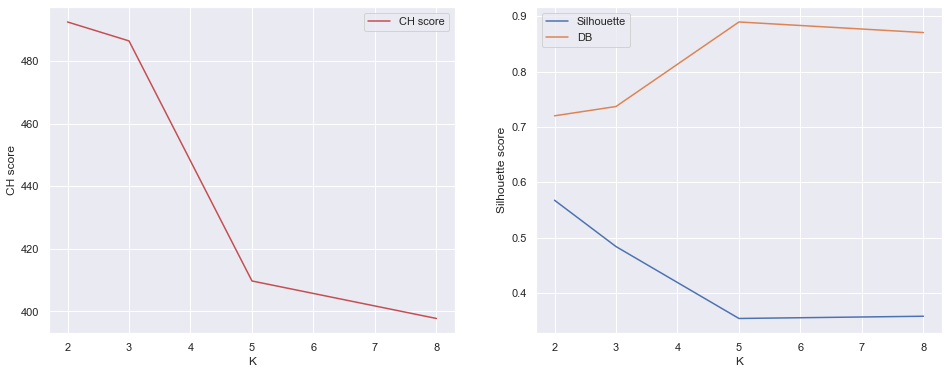

In [21]:
results_df = results_df.sort_index()
results_df = results_df.astype(float)

fig, ax = plt.subplots(1,2, figsize=(16,6))

sns.lineplot(x='K', y='CH score',data=results_df.reset_index(),label='CH score', color='r', ax=ax[0]);
sns.lineplot(x='K', y='Silhouette score',data=results_df.reset_index(),label='Silhouette',ax=ax[1]);
sns.lineplot(x='K', y='DB score',data=results_df.reset_index(),label='DB');

### EM for mixture of gaussians

In [24]:
data = newwholesale
labels = ['Fresh', 'Frozen', 'Detergents_Paper']

# Using diag
gm = GaussianMixture(n_components=3, 
                     covariance_type='diag').fit(data.loc[:,labels])
print('BIC=', gm.bic(data.loc[:,labels]))
print('\nLOG Likelihood=', gm.lower_bound_)
print('\nWEIGHTS=')
pd.DataFrame(gm.weights_)
print('\nMEANS=')
pd.DataFrame(gm.means_)
print('\nCOV=')
pd.DataFrame(gm.covariances_)

BIC= 25049.113796398615

LOG Likelihood= -28.718960199506668

WEIGHTS=


,0
0,0.444
1,0.436
2,0.121



MEANS=


,0,1,2
0,14096.363,4230.766,387.348
1,6017.270,985.262,3922.071
2,22918.726,4483.437,6611.649



COV=


,0,1,2
0,1.064e+08,1.938e+07,8.946e+04
1,2.832e+07,4.814e+05,1.197e+07
2,3.691e+08,1.287e+07,4.928e+07


In [26]:
# gm.means_ to get the centers
data['gm_labels'] = gm.predict(data.loc[:,labels])